In [1]:
import torch
import torch.nn as nn
import pandas as pd
from tqdm.notebook import tqdm  # For displaying progress bars
from datasets import load_dataset  # For loading datasets
from sklearn.model_selection import train_test_split  # For splitting the dataset
from transformers import BertTokenizer  # For tokenizing text
from torch.utils.data import TensorDataset  # For creating Tensor datasets
import time  # For measuring time
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score  # For evaluation metrics
from sklearn.exceptions import UndefinedMetricWarning  # For handling metric warnings
import matplotlib.pyplot as plt  # For plotting
from tabulate import tabulate  # For tabular data formatting
import random  # For randomization
import numpy as np  # For numerical operations
from transformers import (
    BertTokenizer,  # Tokenizer for BERT models
    AdamW,  # Optimizer for BERT models
    get_linear_schedule_with_warmup,  # Learning rate scheduler for BERT models
    BertConfig,  # Configuration for BERT models
    BertForSequenceClassification  # BERT model for sequence classification tasks
)
from torch.utils.data import (
    DataLoader,  # Data loader for creating batches
    RandomSampler,  # Sampler for random sampling of data
    SequentialSampler  # Sampler for sequential sampling of data
)
from sklearn.metrics import f1_score  # For computing the F1 score

# 1. Torch: PyTorch library for deep learning
# 2. Pandas: Library for data manipulation and analysis
# 3. tqdm: Library for displaying progress bars
# 4. datasets: Library for working with datasets
# 5. train_test_split: Function for splitting the dataset into training and validation sets
# 6. BertTokenizer: Tokenizer for BERT models
# 7. TensorDataset: Dataset class for creating PyTorch Tensor datasets
# 8. time: Module for measuring time
# 9. accuracy_score, precision_score, f1_score: Evaluation metrics for classification tasks
# 10. UndefinedMetricWarning: Warning for undefined metric values
# 11. matplotlib.pyplot: Plotting library
# 12. tabulate: Library for formatting tabular data
# 13. random: Module for randomization
# 14. numpy: Library for numerical operations
# 15. AdamW: Optimizer for BERT models
# 16. get_linear_schedule_with_warmup: Learning rate scheduler for BERT models
# 17. BertConfig: Configuration for BERT models
# 18. BertForSequenceClassification: BERT model for sequence classification tasks
# 19. DataLoader: Data loader for creating batches
# 20. RandomSampler: Sampler for random sampling of data
# 21. SequentialSampler: Sampler for sequential sampling of data
# 22. f1_score: Function for computing the F1 score

2023-07-17 21:44:46.759080: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-17 21:44:46.789767: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-17 21:44:47.255092: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def data_imdb():
    dataset = load_dataset("imdb")
    train_data = dataset['train']
    test_data = dataset['test']

    df_train = train_data.to_pandas()  # Convert the training dataset to a Pandas DataFrame
    df_test = test_data.to_pandas()  # Convert the validation dataset to a Pandas DataFrame

    df_train['sentiment'] = df_train['label'].map({0: 'bad', 1: 'good'})
    df_test['sentiment'] = df_test['label'].map({0: 'bad', 1: 'good'})

    possible_labels = df_train.sentiment.unique()  # Get unique category labels from the training DataFrame column 'category'

    label_dict = {}  # Create a dictionary to map each possible label to a unique index
    for index, possible_label in enumerate(possible_labels):
        label_dict[possible_label] = index

    df_train['label'] = df_train.sentiment.replace(label_dict)
    df_test['label'] = df_test.sentiment.replace(label_dict)

    df_train['data_type'] = 'train'  # Set the 'data_type' column to 'train' for training data
    df_test['data_type'] = 'test'  # Set the 'data_type' column to 'val' for validation data

    df = pd.concat([df_train, df_test], ignore_index=True)  # Merge the training and validation dataframes

    return df


def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten() #This line finds the index with the highest probability in each prediction, effectively giving the predicted class for each input.
    labels_flat = labels.flatten()  #This line flattens the labels array into a 1D vector, as required by the f1_score function.
    return f1_score(labels_flat, preds_flat, average='weighted') #This line computes the F1 score using the true labels and the predicted labels, with the weighted averaging scheme. The result is returned.

def accuracy_per_class(preds, labels, label_dict):
    # Create a dictionary with keys and values reversed for easy lookup.
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    # Get the predicted labels and flatten them.
    preds_flat = np.argmax(preds, axis=1).flatten()
    
    # Get the actual labels and flatten them.
    labels_flat = labels.flatten()

    # Initialize the confusion matrix.
    num_classes = len(label_dict)
    confusion_mat = confusion_matrix(labels_flat, preds_flat, labels=list(range(num_classes)))
    
    # Calculate accuracy and F1 score per class
    accuracies = {}
    f1_scores = {}
    for label in range(num_classes):
        # Calculate accuracy for this class
        num_correct = confusion_mat[label, label]
        num_instances = np.sum(confusion_mat[label, :])
        accuracy = num_correct / num_instances * 100
        accuracies[label] = accuracy
        
        # Calculate F1 score for this class
        f1 = f1_score(labels_flat, preds_flat, labels=[label], average='weighted')
        f1_scores[label] = f1

        # Print the class name, accuracy numerator, and denominator.
        class_name = label_dict_inverse[label]
        print(f'Class: {class_name}')
        print(f'Accuracy: {num_correct}/{num_instances} ({accuracy:.2f}%)')
        print(f'F1 Score: {f1:.2f}\n')

    # Calculate total accuracy and F1 score
    total_accuracy = accuracy_score(labels_flat, preds_flat) * 100
    total_f1_score = f1_score(labels_flat, preds_flat, average='weighted')

    # Print the total accuracy and F1 score
    print(f'Total Accuracy: {total_accuracy:.2f}%')
    print(f'Total F1 Score: {total_f1_score:.2f}')


#This code evaluates the performance of a trained model on a validation dataset by computing its loss and predictions for each batch in the dataset.
def evaluate(dataloader_val):

    model.eval() # setting the model to evaluation mode to disable dropout and other regularization techniques that are useful during training but not during evaluation.
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
    
        batch = tuple(b.to(device) for b in batch) # moving the input batch to the GPU for faster computation.
   
        #  creating a dictionary of inputs that will be passed to the model. The input IDs and attention mask are for the BERT model, and the labels are the true labels for each input.
        inputs = {'input_ids':  	batch[0],
                'attention_mask': batch[1],
                'labels':     	batch[2],
                } 

        with torch.no_grad():   
            outputs = model(**inputs)
        
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val)
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
       	 
    return loss_val_avg, predictions, true_vals

def train_model(trainer, dataloader_train, dataloader_val, epochs, patience):
    total_training_time = 0
    
    training_loss_list = []
    validation_loss_list = []
    accuracy_list = []
    precision_list = []
    f1_score_list = []
    
    previous_results = None  # Store previous epoch results
    best_val_loss = float('inf')
    counter = 0
    
    for epoch in tqdm(range(1, epochs + 1)):
        start_time = time.time()
    
        model.train()
        loss_train_total = 0
    
        progress_bar = tqdm(dataloader_train,
                            desc='Epoch {:1d}'.format(epoch),
                            leave=False,
                            disable=False)
        for batch in progress_bar:
            model.zero_grad()
            batch = tuple(b.to(device) for b in batch)
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1],
                'labels': batch[2],
            }
            output = model(**inputs)
            loss = output[0]
            loss_train_total += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
    
        end_time = time.time()
        epoch_training_time = end_time - start_time
        total_training_time += epoch_training_time
    
        torch.save(model.state_dict(), f'Models/finetuned_gpt_bert_imdb_ft_epoch{epoch}.model')
    
        tqdm.write(f'\nEpoch {epoch}')
    
        loss_train_avg = loss_train_total / len(dataloader_train)
        tqdm.write(f'Training loss: {loss_train_avg}')
    
        val_loss, predictions, true_vals = evaluate(dataloader_val)
    
        # Convert predictions to discrete labels
        predictions = np.argmax(predictions, axis=1)
    
        val_f1 = f1_score(true_vals, predictions, average='weighted')
        tqdm.write(f'Validation loss: {val_loss}')
        tqdm.write(f'F1 Score (weighted): {val_f1}')
    
        val_accuracy = accuracy_score(true_vals, predictions)
        val_precision = precision_score(true_vals, predictions, average='weighted', zero_division=1)
    
        # Compute and store metrics
        training_loss_list.append(loss_train_avg)
        validation_loss_list.append(val_loss)
        f1_score_list.append(val_f1)
        accuracy_list.append(val_accuracy)
        precision_list.append(val_precision)
    
        # Check if there are previous results to compare with
        if previous_results is not None:
            if loss_train_avg > previous_results['loss_train_avg']:
                percentage_increase = ((loss_train_avg - previous_results['loss_train_avg']) / previous_results['loss_train_avg']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Training loss increased compared to the previous epoch' + '\033[0m')
            if loss_train_avg < previous_results['loss_train_avg']:
                percentage_decrease = ((previous_results['loss_train_avg'] - loss_train_avg) / previous_results['loss_train_avg']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Training loss decreased compared to the previous epoch' + '\033[0m')
            if val_loss > previous_results['val_loss']:
                percentage_increase = ((val_loss - previous_results['val_loss']) / previous_results['val_loss']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Validation loss increased compared to the previous epoch' + '\033[0m')
            if val_loss < previous_results['val_loss']:
                percentage_decrease = ((previous_results['val_loss'] - val_loss) / previous_results['val_loss']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Validation loss decreased compared to the previous epoch' + '\033[0m')
            if val_f1 < previous_results['val_f1']:
                percentage_decrease = ((previous_results['val_f1'] - val_f1) / previous_results['val_f1']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_decrease, 2)}% F1 Score decreased compared to the previous epoch' + '\033[0m')
            if val_f1 > previous_results['val_f1']:
                percentage_increase = ((val_f1 - previous_results['val_f1']) / previous_results['val_f1']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_increase, 2)}% F1 Score increased compared to the previous epoch' + '\033[0m')
    
        # Store current results as previous results for the next epoch
        previous_results = {
            'loss_train_avg': loss_train_avg,
            'val_loss': val_loss,
            'val_f1': val_f1
        }
        
        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                tqdm.write('\nEarly stopping triggered. Training stopped.')
                break
    
    total_time_minutes = total_training_time / 60
    tqdm.write(f'\nTotal training time: {total_time_minutes} minutes')
    
    final_accuracy = accuracy_list[-1]
    final_precision = precision_list[-1]
    tqdm.write(f'Final Accuracy: {final_accuracy}')
    tqdm.write(f'Final Precision: {final_precision}')
    
    # Create the x-axis values based on the actual number of epochs completed
    x_values = range(1, len(training_loss_list) + 1)
    
    # Create the metrics subplot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot training loss
    ax.plot(x_values, training_loss_list, label='Training Loss')
    
    # Plot validation loss
    ax.plot(x_values, validation_loss_list, label='Validation Loss')
    
    # Plot F1-score
    ax.plot(x_values, f1_score_list, label='F1 Score')

    # Plot Accuracy
    ax.plot(x_values, accuracy_list, label='Accuracy')
    
    # Set labels and title
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Metric Value')
    ax.set_title('Training Loss, Validation Loss, and F1 Score')
    
    # Set legend
    ax.legend()
    
    # Show the combined plot
    plt.show()
    
    
    # Create the metrics table
    metrics_table = [
        ['Epoch', 'Training Loss', 'Validation Loss', 'F1 Score', 'Accuracy', 'Precision'],
    ]
    previous_results = None
    for epoch in range(1, len(training_loss_list) + 1):
        row = [
            epoch,
            training_loss_list[epoch - 1],
            validation_loss_list[epoch - 1],
            f1_score_list[epoch - 1],
            accuracy_list[epoch - 1],
            precision_list[epoch - 1]
        ]
    
        # Compare with previous epoch results
        if previous_results is not None:
            if training_loss_list[epoch - 1] < previous_results['loss_train_avg']:
                row[1] = '\033[92m' + str(row[1]) + '\033[0m'  # Highlight in green
            if training_loss_list[epoch - 1] > previous_results['loss_train_avg']:
                row[1] = '\033[91m' + str(row[1]) + '\033[0m'  # Highlight in red
            if validation_loss_list[epoch - 1] < previous_results['val_loss']:
                row[2] = '\033[92m' + str(row[2]) + '\033[0m'  # Highlight in green
            if validation_loss_list[epoch - 1] > previous_results['val_loss']:
                row[2] = '\033[91m' + str(row[2]) + '\033[0m'  # Highlight in red
            if f1_score_list[epoch - 1] > previous_results['val_f1']:
                row[3] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if f1_score_list[epoch - 1] < previous_results['val_f1']:
                row[3] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
            if accuracy_list[epoch - 1] > previous_results['val_f1']:
                row[4] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if accuracy_list[epoch - 1] < previous_results['val_f1']:
                row[4] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
            if precision_list[epoch - 1] > previous_results['val_f1']:
                row[5] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if precision_list[epoch - 1] < previous_results['val_f1']:
                row[5] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
    
        metrics_table.append(row)
        previous_results = {
            'loss_train_avg': training_loss_list[epoch - 1],
            'val_loss': validation_loss_list[epoch - 1],
            'val_f1': f1_score_list[epoch - 1]
        }
    
    # Calculate total training time in minutes
    total_time_minutes = total_training_time / 60
    
    # Calculate total precision
    total_precision = precision_list[-1]
    
    # Add total training time and total precision rows to the table
    metrics_table.append(['Total Training Time', '', '', '', '', total_training_time])
    metrics_table.append(['Final Precision', '', '', '', '', total_precision])
    metrics_table.append(['Total Time (minutes)', '', '', '', '', total_time_minutes])
    
    # Print the table
    print(tabulate(metrics_table, headers='firstrow'))

    return training_loss_list, validation_loss_list, accuracy_list, precision_list, f1_score_list

default_args = {
    "output_dir": "tmp",
    "evaluation_strategy": "steps",
    "num_train_epochs": 1,
    "log_level": "error",
    "report_to": "none",
}

In [3]:
df = data_imdb()

Found cached dataset imdb (/home/z123010/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# Create label_dict and assign the number of labels
label_dict = {label: index for index, label in enumerate(df['label'].unique())}

In [5]:
df.sample(n=10, random_state=42)  # Generate 10 random rows from df

,text,label,sentiment,data_type
33553,Forget what I said about Emeril. Rachael Ray i...,0,bad,test
9427,Former private eye-turned-security guard ditch...,0,bad,train
199,Mann photographs the Alberta Rocky Mountains i...,0,bad,train
12447,Simply put: the movie is boring. Cliché upon c...,0,bad,train
39489,"Now being a fan of sci fi, the trailer for thi...",1,good,test
42724,"In 'Hoot' Logan Lerman plays Roy Eberhardt, th...",1,good,test
10822,This is the worst film I have ever seen.I was ...,0,bad,train
49498,I think that Toy Soldiers is an excellent movi...,1,good,test
4144,I think Micheal Ironsides acting career must b...,0,bad,train
36958,This was a disgrace to the game FarCry i had m...,0,bad,test


In [6]:
df.groupby(['sentiment']).count()

,text,label,data_type
sentiment,,,
bad,25000,25000,25000
good,25000,25000,25000


In [7]:
df.groupby(['data_type']).count()

,text,label,sentiment
data_type,,,
test,25000,25000,25000
train,25000,25000,25000


In [8]:
# Load BERT tokenizer
pretrained_path = 'bert-base-uncased'  # Replace with the path to the pretrained BERT model
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

encoded_data_train_text = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=512,
    truncation=True,
    return_tensors='pt'
)

input_ids_train = encoded_data_train_text['input_ids']
attention_masks_train = encoded_data_train_text['attention_mask']

labels_train = torch.tensor(df[df.data_type=='train'].label.values)

encoded_data_test_text = tokenizer.batch_encode_plus(
    df[df.data_type=='test'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=512,
    truncation=True,
    return_tensors='pt'
)

input_ids_test = encoded_data_test_text['input_ids']
attention_masks_test = encoded_data_test_text['attention_mask']

labels_test = torch.tensor(df[df.data_type=='test'].label.values)

In [9]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)
len(dataset_train), len(dataset_test)

(25000, 25000)

In [10]:
from transformers import BertModel, BertConfig, GPT2Model, GPT2Config

num_classes = 2

class SentimentModel(nn.Module):
    def __init__(self, pretrained_bert_path, pretrained_gpt_path):
        super(SentimentModel, self).__init__()

        # Create a new GPT-2 configuration with modified hidden size and attention heads
        gpt_config = GPT2Config(
            vocab_size=50257,
            hidden_size=512,
            num_hidden_layers=6,
            num_attention_heads=8,
            intermediate_size=1024,
            hidden_dropout_prob=0.3,
            attention_probs_dropout_prob=0.3,
        )
        self.gpt = GPT2Model(config=gpt_config)
        
        # Create a new BERT configuration with modified hidden size and attention heads
        bert_config = BertConfig(
            vocab_size=50257,
            hidden_size=512,
            num_hidden_layers=6,
            num_attention_heads=8,
            intermediate_size=1024,
            hidden_dropout_prob=0.3,
            attention_probs_dropout_prob=0.3,
        )
        self.bert = BertModel(config=bert_config)
        
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(bert_config.hidden_size + gpt_config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, labels=None):
        gpt_outputs = self.gpt(input_ids, attention_mask=attention_mask)[0]
        bert_outputs = self.bert(input_ids, attention_mask=attention_mask)[0]
        
        gpt_last_hidden_state = self.dropout(gpt_outputs[:, -1, :])  # Use the last hidden state
        bert_pooled_output = self.dropout(bert_outputs[:, 0, :])  # Use the [CLS] token representation
        
        combined_outputs = torch.cat((gpt_last_hidden_state, bert_pooled_output), dim=1)
        
        logits = self.fc(combined_outputs)
        outputs = nn.functional.softmax(logits, dim=1)
        
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits.view(-1, num_classes), labels.view(-1))
            return loss, outputs, labels
        else:
            return outputs


In [11]:
# Create model instance
model = SentimentModel('bert-base-uncased', 'gpt2')

In [12]:
# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SentimentModel(
  (gpt): GPT2Model(
    (wte): Embedding(50257, 512)
    (wpe): Embedding(1024, 512)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50257, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings

In [13]:
from transformers import TrainingArguments, Trainer, logging
training_args = TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    fp16=True,
    **default_args,
)

In [14]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
# Set the batch size and create data loaders for training and validation sets

batch_size = 12 #32

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_test = DataLoader(
    dataset_test,
    sampler=RandomSampler(dataset_test),
    batch_size=batch_size
)

In [15]:
from transformers import AdamW, get_linear_schedule_with_warmup

# Define the optimizer
optimizer = AdamW(
    model.parameters(),
    lr=1e-5,
    eps=1e-8,
)


epochs = 50
patience = 10
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train) * epochs
)

/home/z123010/anaconda3/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
import random

seed_val = 17
random.seed(seed_val) #sets the seed value for the Python built-in pseudo-random generator.
np.random.seed(seed_val) #sets the seed value for the NumPy pseudo-random number generator.
torch.manual_seed(seed_val) #sets the seed value for the random number generator in PyTorch on the CPU.
torch.cuda.manual_seed_all(seed_val) #sets the seed value for the random number generator in PyTorch on the GPU.

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [18]:
trainer = Trainer(
model=model,
args=training_args,
train_dataset=dataset_train,
eval_dataset=dataset_train,
)


Fold 1


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.510927251235644
Validation loss: 0.38108036788314154
F1 Score (weighted): 0.847052601428328


Epoch 2:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.31905039540628594
Validation loss: 0.32622096325720895
F1 Score (weighted): 0.875201495622981
37.55% Training loss decreased compared to the previous epoch
14.4% Validation loss decreased compared to the previous epoch
3.32% F1 Score increased compared to the previous epoch


Epoch 3:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.27117424307720117
Validation loss: 0.46282688509360953
F1 Score (weighted): 0.8652153948205816
15.01% Training loss decreased compared to the previous epoch
41.88% Validation loss increased compared to the previous epoch
1.14% F1 Score decreased compared to the previous epoch


Epoch 4:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.24156400063379357
Validation loss: 0.39070286606906346
F1 Score (weighted): 0.8880413029059033
10.92% Training loss decreased compared to the previous epoch
15.58% Validation loss decreased compared to the previous epoch
2.64% F1 Score increased compared to the previous epoch


Epoch 5:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.20974395736362786
Validation loss: 0.5199094894386685
F1 Score (weighted): 0.8860287538784906
13.17% Training loss decreased compared to the previous epoch
33.07% Validation loss increased compared to the previous epoch
0.23% F1 Score decreased compared to the previous epoch


Epoch 6:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.1858344683152934
Validation loss: 0.5496713462665579
F1 Score (weighted): 0.879625872748356
11.4% Training loss decreased compared to the previous epoch
5.72% Validation loss increased compared to the previous epoch
0.72% F1 Score decreased compared to the previous epoch


Epoch 7:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.16498587396591902
Validation loss: 0.5284011133670201
F1 Score (weighted): 0.8860354657929511
11.22% Training loss decreased compared to the previous epoch
3.87% Validation loss decreased compared to the previous epoch
0.73% F1 Score increased compared to the previous epoch


Epoch 8:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.1384559052112202
Validation loss: 0.5465288844868055
F1 Score (weighted): 0.8852370365567124
16.08% Training loss decreased compared to the previous epoch
3.43% Validation loss increased compared to the previous epoch
0.09% F1 Score decreased compared to the previous epoch


Epoch 9:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.12585717546092345
Validation loss: 0.7152389874925523
F1 Score (weighted): 0.8861521145311272
9.1% Training loss decreased compared to the previous epoch
30.87% Validation loss increased compared to the previous epoch
0.1% F1 Score increased compared to the previous epoch


Epoch 10:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.10426427920698188
Validation loss: 0.6296302438070263
F1 Score (weighted): 0.8824162009315343
17.16% Training loss decreased compared to the previous epoch
11.97% Validation loss decreased compared to the previous epoch
0.42% F1 Score decreased compared to the previous epoch


Epoch 11:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.09520500121772445
Validation loss: 0.7372539950338076
F1 Score (weighted): 0.8824
8.69% Training loss decreased compared to the previous epoch
17.09% Validation loss increased compared to the previous epoch
0.0% F1 Score decreased compared to the previous epoch


Epoch 12:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.07453166691842877
Validation loss: 0.848151477504662
F1 Score (weighted): 0.8790733408712523
21.71% Training loss decreased compared to the previous epoch
15.04% Validation loss increased compared to the previous epoch
0.38% F1 Score decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 140.18742560545604 minutes
Final Accuracy: 0.8792
Final Precision: 0.8795447726149282


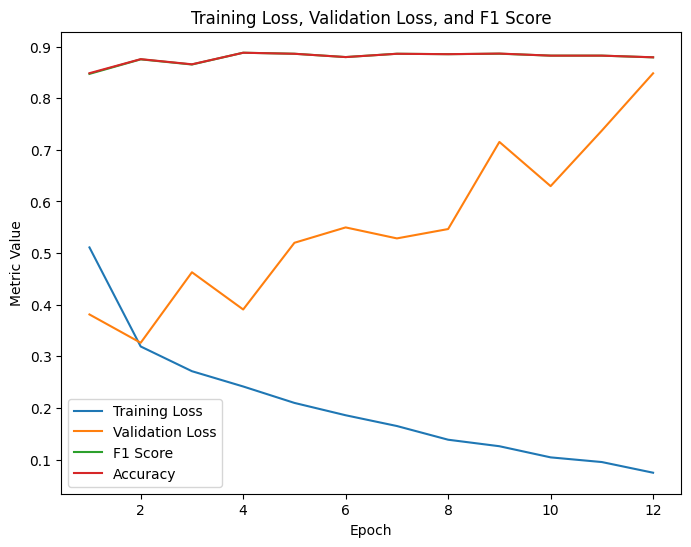

Epoch                 Training Loss        Validation Loss      F1 Score            Accuracy              Precision
--------------------  -------------------  -------------------  ------------------  ------------------  -----------
1                     0.510927251235644    0.38108036788314154  0.847052601428328   0.8484                 0.85592
2                     0.31905039540628594  0.32622096325720895  0.875201495622981   0.875201495622981      0.875201
3                     0.27117424307720117  0.46282688509360953  0.8652153948205816  0.8652153948205816     0.865215
4                     0.24156400063379357  0.39070286606906346  0.8880413029059033  0.8880413029059033     0.888041
5                     0.20974395736362786  0.5199094894386685   0.8860287538784906  0.8860287538784906     0.886029
6                     0.1858344683152934   0.5496713462665579   0.879625872748356   0.879625872748356      0.879626
7                     0.16498587396591902  0.5284011133670201   0.8860354

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.1285144797718618
Validation loss: 0.02335560234886278
F1 Score (weighted): 0.9948000541165828


Epoch 2:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.09511354985539025
Validation loss: 0.048576845441700926
F1 Score (weighted): 0.9880018591358859
25.99% Training loss decreased compared to the previous epoch
107.99% Validation loss increased compared to the previous epoch
0.68% F1 Score decreased compared to the previous epoch


Epoch 3:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.07561659003252862
Validation loss: 0.067168343147713
F1 Score (weighted): 0.9867974312234011
20.5% Training loss decreased compared to the previous epoch
38.27% Validation loss increased compared to the previous epoch
0.12% F1 Score decreased compared to the previous epoch


Epoch 4:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.05703549031409978
Validation loss: 0.07251429782787525
F1 Score (weighted): 0.985996835872372
24.57% Training loss decreased compared to the previous epoch
7.96% Validation loss increased compared to the previous epoch
0.08% F1 Score decreased compared to the previous epoch


Epoch 5:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.05523715633278868
Validation loss: 0.08985454210172948
F1 Score (weighted): 0.9840020488195278
3.15% Training loss decreased compared to the previous epoch
23.91% Validation loss increased compared to the previous epoch
0.2% F1 Score decreased compared to the previous epoch


Epoch 6:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.047982386250295286
Validation loss: 0.2537213948479189
F1 Score (weighted): 0.9566810186673387
13.13% Training loss decreased compared to the previous epoch
182.37% Validation loss increased compared to the previous epoch
2.78% F1 Score decreased compared to the previous epoch


Epoch 7:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.0383380345925844
Validation loss: 0.12617961449912957
F1 Score (weighted): 0.9799951561314661
20.1% Training loss decreased compared to the previous epoch
50.27% Validation loss decreased compared to the previous epoch
2.44% F1 Score increased compared to the previous epoch


Epoch 8:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.03588212771706264
Validation loss: 0.18118651294145002
F1 Score (weighted): 0.9728042130622594
6.41% Training loss decreased compared to the previous epoch
43.59% Validation loss increased compared to the previous epoch
0.73% F1 Score decreased compared to the previous epoch


Epoch 9:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.03570881100693368
Validation loss: 0.1516470842376058
F1 Score (weighted): 0.9771870832377774
0.48% Training loss decreased compared to the previous epoch
16.3% Validation loss decreased compared to the previous epoch
0.45% F1 Score increased compared to the previous epoch


Epoch 10:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.024441579529774996
Validation loss: 0.17072441501685887
F1 Score (weighted): 0.9752
31.55% Training loss decreased compared to the previous epoch
12.58% Validation loss increased compared to the previous epoch
0.2% F1 Score decreased compared to the previous epoch


Epoch 11:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.021438472271136804
Validation loss: 0.23174262548947294
F1 Score (weighted): 0.966762667198728
12.29% Training loss decreased compared to the previous epoch
35.74% Validation loss increased compared to the previous epoch
0.87% F1 Score decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 128.57357314427693 minutes
Final Accuracy: 0.9668
Final Precision: 0.9677355275347399


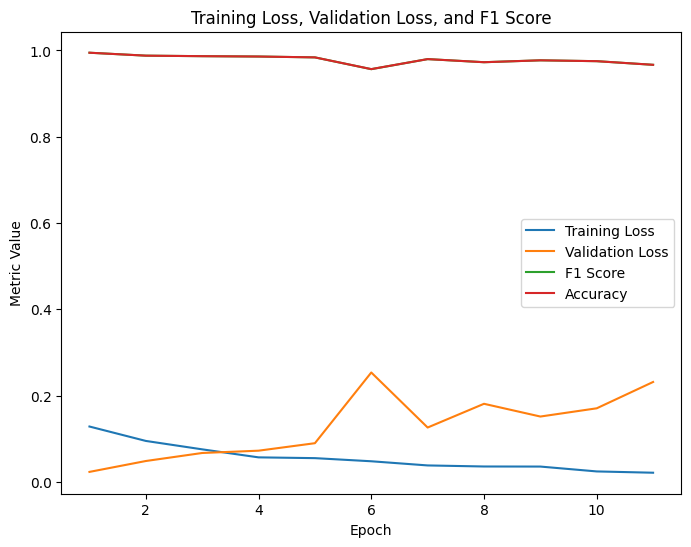

Epoch                 Training Loss         Validation Loss       F1 Score            Accuracy              Precision
--------------------  --------------------  --------------------  ------------------  ------------------  -----------
1                     0.1285144797718618    0.02335560234886278   0.9948000541165828  0.9948                 0.9948
2                     0.09511354985539025   0.048576845441700926  0.9880018591358859  0.9880018591358859     0.988002
3                     0.07561659003252862   0.067168343147713     0.9867974312234011  0.9867974312234011     0.986797
4                     0.05703549031409978   0.07251429782787525   0.985996835872372   0.985996835872372      0.985997
5                     0.05523715633278868   0.08985454210172948   0.9840020488195278  0.9840020488195278     0.984002
6                     0.047982386250295286  0.2537213948479189    0.9566810186673387  0.9566810186673387     0.956681
7                     0.0383380345925844    0.126179614499

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.03983130563705199
Validation loss: 0.00028980265396009937
F1 Score (weighted): 1.0


Epoch 2:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.025213871677833472
Validation loss: 0.004597955653184401
F1 Score (weighted): 0.9988000132491214
36.7% Training loss decreased compared to the previous epoch
1486.58% Validation loss increased compared to the previous epoch
0.12% F1 Score decreased compared to the previous epoch


Epoch 3:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.0199158302564756
Validation loss: 0.005950303158845221
F1 Score (weighted): 0.9987999832937521
21.01% Training loss decreased compared to the previous epoch
29.41% Validation loss increased compared to the previous epoch
0.0% F1 Score decreased compared to the previous epoch


Epoch 4:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.017222091477569
Validation loss: 0.010061437206138254
F1 Score (weighted): 0.9980000220818692
13.53% Training loss decreased compared to the previous epoch
69.09% Validation loss increased compared to the previous epoch
0.08% F1 Score decreased compared to the previous epoch


Epoch 5:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.01606775985265655
Validation loss: 0.0023151647120122675
F1 Score (weighted): 0.9996000016001599
6.7% Training loss decreased compared to the previous epoch
76.99% Validation loss decreased compared to the previous epoch
0.16% F1 Score increased compared to the previous epoch


Epoch 6:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.014605428302255556
Validation loss: 0.00444552019141056
F1 Score (weighted): 0.9992
9.1% Training loss decreased compared to the previous epoch
92.02% Validation loss increased compared to the previous epoch
0.04% F1 Score decreased compared to the previous epoch


Epoch 7:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.013339596842533986
Validation loss: 0.005106835069060061
F1 Score (weighted): 0.9992000061445662
8.67% Training loss decreased compared to the previous epoch
14.88% Validation loss increased compared to the previous epoch
0.0% F1 Score increased compared to the previous epoch


Epoch 8:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.012670246550354326
Validation loss: 0.0032210833795971758
F1 Score (weighted): 0.9992
5.02% Training loss decreased compared to the previous epoch
36.93% Validation loss decreased compared to the previous epoch
0.0% F1 Score decreased compared to the previous epoch


Epoch 9:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.010195774157931495
Validation loss: 0.004744258207667729
F1 Score (weighted): 0.9992000061445662
19.53% Training loss decreased compared to the previous epoch
47.29% Validation loss increased compared to the previous epoch
0.0% F1 Score increased compared to the previous epoch


Epoch 10:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.01087671224969005
Validation loss: 0.006929803907727172
F1 Score (weighted): 0.9987999832937521
6.68% Training loss increased compared to the previous epoch
46.07% Validation loss increased compared to the previous epoch
0.04% F1 Score decreased compared to the previous epoch


Epoch 11:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.009935062550298366
Validation loss: 0.0214333343095028
F1 Score (weighted): 0.9968000737318221
8.66% Training loss decreased compared to the previous epoch
209.29% Validation loss increased compared to the previous epoch
0.2% F1 Score decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 128.61835205952326 minutes
Final Accuracy: 0.9968
Final Precision: 0.9968205622489961


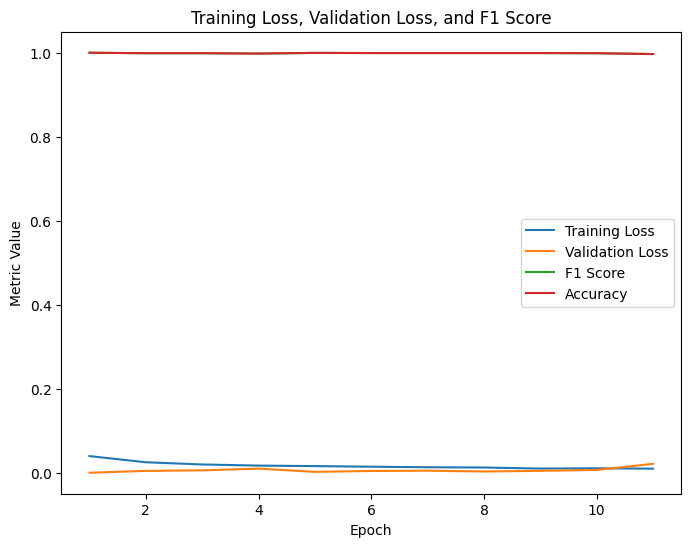

Epoch                 Training Loss         Validation Loss         F1 Score            Accuracy              Precision
--------------------  --------------------  ----------------------  ------------------  ------------------  -----------
1                     0.03983130563705199   0.00028980265396009937  1.0                 1.0                    1
2                     0.025213871677833472  0.004597955653184401    0.9988000132491214  0.9988000132491214     0.9988
3                     0.0199158302564756    0.005950303158845221    0.9987999832937521  0.9987999832937521     0.9988
4                     0.017222091477569     0.010061437206138254    0.9980000220818692  0.9980000220818692     0.998
5                     0.01606775985265655   0.0023151647120122675   0.9996000016001599  0.9996000016001599     0.9996
6                     0.014605428302255556  0.00444552019141056     0.9992              0.9992                 0.9992
7                     0.013339596842533986  0.005106835069

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.015643054434894294
Validation loss: 0.004280044853588556
F1 Score (weighted): 0.999600004547668


Epoch 2:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.008726915990664202
Validation loss: 0.004646694346715058
F1 Score (weighted): 0.999600004547668
44.21% Training loss decreased compared to the previous epoch
8.57% Validation loss increased compared to the previous epoch


Epoch 3:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.006667301347485409
Validation loss: 0.004858472457184968
F1 Score (weighted): 0.999600004547668
23.6% Training loss decreased compared to the previous epoch
4.56% Validation loss increased compared to the previous epoch


Epoch 4:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.009290549482696467
Validation loss: 0.004456123760827283
F1 Score (weighted): 0.999600004547668
39.34% Training loss increased compared to the previous epoch
8.28% Validation loss decreased compared to the previous epoch


Epoch 5:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.007596028238096672
Validation loss: 0.004748734808328172
F1 Score (weighted): 0.999600004547668
18.24% Training loss decreased compared to the previous epoch
6.57% Validation loss increased compared to the previous epoch


Epoch 6:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.006630176438847775
Validation loss: 0.0049451663981985436
F1 Score (weighted): 0.999600004547668
12.72% Training loss decreased compared to the previous epoch
4.14% Validation loss increased compared to the previous epoch


Epoch 7:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.005444222737338411
Validation loss: 0.005015016754097279
F1 Score (weighted): 0.999600004547668
17.89% Training loss decreased compared to the previous epoch
1.41% Validation loss increased compared to the previous epoch


Epoch 8:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.004895590497191491
Validation loss: 0.005166667200494942
F1 Score (weighted): 0.999600004547668
10.08% Training loss decreased compared to the previous epoch
3.02% Validation loss increased compared to the previous epoch


Epoch 9:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.004250548580618549
Validation loss: 0.005210590311998765
F1 Score (weighted): 0.999600004547668
13.18% Training loss decreased compared to the previous epoch
0.85% Validation loss increased compared to the previous epoch


Epoch 10:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.002287251712504379
Validation loss: 0.005272266297174774
F1 Score (weighted): 0.999600004547668
46.19% Training loss decreased compared to the previous epoch
1.18% Validation loss increased compared to the previous epoch


Epoch 11:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.0024251053794047037
Validation loss: 0.005312125882592694
F1 Score (weighted): 0.999600004547668
6.03% Training loss increased compared to the previous epoch
0.76% Validation loss increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 128.67220027844112 minutes
Final Accuracy: 0.9996
Final Precision: 0.999600329218107


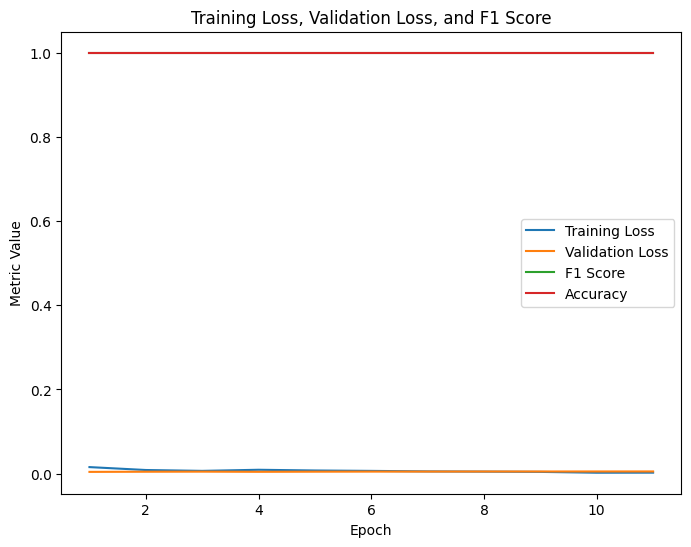

Epoch                 Training Loss          Validation Loss        F1 Score           Accuracy             Precision
--------------------  ---------------------  ---------------------  -----------------  -----------------  -----------
1                     0.015643054434894294   0.004280044853588556   0.999600004547668  0.9996                  0.9996
2                     0.008726915990664202   0.004646694346715058   0.999600004547668  0.999600004547668       0.9996
3                     0.006667301347485409   0.004858472457184968   0.999600004547668  0.999600004547668       0.9996
4                     0.009290549482696467   0.004456123760827283   0.999600004547668  0.999600004547668       0.9996
5                     0.007596028238096672   0.004748734808328172   0.999600004547668  0.999600004547668       0.9996
6                     0.006630176438847775   0.0049451663981985436  0.999600004547668  0.999600004547668       0.9996
7                     0.005444222737338411   0.005015016

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.005031202268288083
Validation loss: 8.040444773480898e-07
F1 Score (weighted): 1.0


Epoch 2:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.006244307469535306
Validation loss: 9.843316679812168e-07
F1 Score (weighted): 1.0
24.11% Training loss increased compared to the previous epoch
22.42% Validation loss increased compared to the previous epoch


Epoch 3:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.0035863814249769955
Validation loss: 1.2315906454631568e-06
F1 Score (weighted): 1.0
42.57% Training loss decreased compared to the previous epoch
25.12% Validation loss increased compared to the previous epoch


Epoch 4:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.00402345399314842
Validation loss: 1.6030967700995836e-06
F1 Score (weighted): 1.0
12.19% Training loss increased compared to the previous epoch
30.16% Validation loss increased compared to the previous epoch


Epoch 5:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.0016107675513031305
Validation loss: 1.7658439604968463e-06
F1 Score (weighted): 1.0
59.97% Training loss decreased compared to the previous epoch
10.15% Validation loss increased compared to the previous epoch


Epoch 6:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.0017304050210558974
Validation loss: 1.960343022771219e-06
F1 Score (weighted): 1.0
7.43% Training loss increased compared to the previous epoch
11.01% Validation loss increased compared to the previous epoch


Epoch 7:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.0016642143625730872
Validation loss: 1.9367197771978018e-06
F1 Score (weighted): 1.0
3.83% Training loss decreased compared to the previous epoch
1.21% Validation loss decreased compared to the previous epoch


Epoch 8:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.0010666738753023917
Validation loss: 2.1718099723173285e-06
F1 Score (weighted): 1.0
35.91% Training loss decreased compared to the previous epoch
12.14% Validation loss increased compared to the previous epoch


Epoch 9:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.0015529670122034077
Validation loss: 2.3964906766491693e-06
F1 Score (weighted): 1.0
45.59% Training loss increased compared to the previous epoch
10.35% Validation loss increased compared to the previous epoch


Epoch 10:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.0016340603262789955
Validation loss: 2.4978748793558587e-06
F1 Score (weighted): 1.0
5.22% Training loss increased compared to the previous epoch
4.23% Validation loss increased compared to the previous epoch


Epoch 11:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.002353604737962875
Validation loss: 2.529863424654924e-06
F1 Score (weighted): 1.0
44.03% Training loss increased compared to the previous epoch
1.28% Validation loss increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 128.78352458874386 minutes
Final Accuracy: 1.0
Final Precision: 1.0


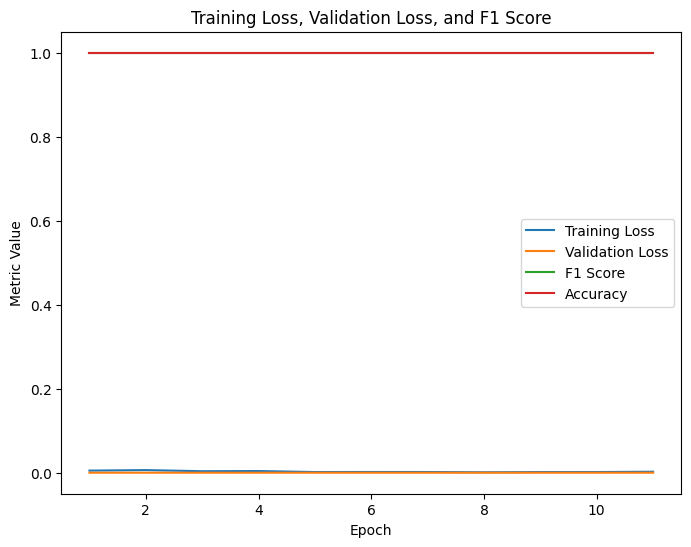

Epoch                 Training Loss          Validation Loss         F1 Score    Accuracy      Precision
--------------------  ---------------------  ----------------------  ----------  ----------  -----------
1                     0.005031202268288083   8.040444773480898e-07   1.0         1.0               1
2                     0.006244307469535306   9.843316679812168e-07   1.0         1.0               1
3                     0.0035863814249769955  1.2315906454631568e-06  1.0         1.0               1
4                     0.00402345399314842    1.6030967700995836e-06  1.0         1.0               1
5                     0.0016107675513031305  1.7658439604968463e-06  1.0         1.0               1
6                     0.0017304050210558974  1.960343022771219e-06   1.0         1.0               1
7                     0.0016642143625730872  1.9367197771978018e-06  1.0         1.0               1
8                     0.0010666738753023917  2.1718099723173285e-06  1.0         1.

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.0020075899842452905
Validation loss: 2.612090539018523e-06
F1 Score (weighted): 1.0


Epoch 2:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.0024050825350351262
Validation loss: 2.617223954489005e-06
F1 Score (weighted): 1.0
19.8% Training loss increased compared to the previous epoch
0.2% Validation loss increased compared to the previous epoch


Epoch 3:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.0030567005554245044
Validation loss: 2.6142769944711522e-06
F1 Score (weighted): 1.0
27.09% Training loss increased compared to the previous epoch
0.11% Validation loss decreased compared to the previous epoch


Epoch 4:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.0021501278729897117
Validation loss: 2.615893067284203e-06
F1 Score (weighted): 1.0
29.66% Training loss decreased compared to the previous epoch
0.06% Validation loss increased compared to the previous epoch


Epoch 5:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.002073054063135108
Validation loss: 2.6098090410975804e-06
F1 Score (weighted): 1.0
3.58% Training loss decreased compared to the previous epoch
0.23% Validation loss decreased compared to the previous epoch


Epoch 6:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.0027776752467627377
Validation loss: 2.615227635920816e-06
F1 Score (weighted): 1.0
33.99% Training loss increased compared to the previous epoch
0.21% Validation loss increased compared to the previous epoch


Epoch 7:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.00309117251724468
Validation loss: 2.608668284521723e-06
F1 Score (weighted): 1.0
11.29% Training loss increased compared to the previous epoch
0.25% Validation loss decreased compared to the previous epoch


Epoch 8:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.0012671557999035334
Validation loss: 2.611615221421439e-06
F1 Score (weighted): 1.0
59.01% Training loss decreased compared to the previous epoch
0.11% Validation loss increased compared to the previous epoch


Epoch 9:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.0024292830154218487
Validation loss: 2.6143720538021064e-06
F1 Score (weighted): 1.0
91.71% Training loss increased compared to the previous epoch
0.11% Validation loss increased compared to the previous epoch


Epoch 10:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.0028208916310632653
Validation loss: 2.61579799217852e-06
F1 Score (weighted): 1.0
16.12% Training loss increased compared to the previous epoch
0.05% Validation loss increased compared to the previous epoch


Epoch 11:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.001165917685915277
Validation loss: 2.6113300551236335e-06
F1 Score (weighted): 1.0
58.67% Training loss decreased compared to the previous epoch
0.17% Validation loss decreased compared to the previous epoch


Epoch 12:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.0023143811581281624
Validation loss: 2.6108547266474264e-06
F1 Score (weighted): 1.0
98.5% Training loss increased compared to the previous epoch
0.02% Validation loss decreased compared to the previous epoch


Epoch 13:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.002680169467598959
Validation loss: 2.6081929788916746e-06
F1 Score (weighted): 1.0
15.81% Training loss increased compared to the previous epoch
0.1% Validation loss decreased compared to the previous epoch


Epoch 14:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.004243331896566633
Validation loss: 2.610759677923617e-06
F1 Score (weighted): 1.0
58.32% Training loss increased compared to the previous epoch
0.1% Validation loss increased compared to the previous epoch


Epoch 15:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.0027637731925102345
Validation loss: 2.609713961096292e-06
F1 Score (weighted): 1.0
34.87% Training loss decreased compared to the previous epoch
0.04% Validation loss decreased compared to the previous epoch


Epoch 16:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.003565258688237494
Validation loss: 2.6081929840592582e-06
F1 Score (weighted): 1.0
29.0% Training loss increased compared to the previous epoch
0.06% Validation loss decreased compared to the previous epoch


Epoch 17:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.0037656563216685148
Validation loss: 2.6145622021096258e-06
F1 Score (weighted): 1.0
5.62% Training loss increased compared to the previous epoch
0.24% Validation loss increased compared to the previous epoch


Epoch 18:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.0025594123002889925
Validation loss: 2.609333727580168e-06
F1 Score (weighted): 1.0
32.03% Training loss decreased compared to the previous epoch
0.2% Validation loss decreased compared to the previous epoch


Epoch 19:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 19
Training loss: 0.002458587646074799
Validation loss: 2.6082880189121855e-06
F1 Score (weighted): 1.0
3.94% Training loss decreased compared to the previous epoch
0.04% Validation loss decreased compared to the previous epoch


Epoch 20:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 20
Training loss: 0.001473292772472208
Validation loss: 2.6083830776991836e-06
F1 Score (weighted): 1.0
40.08% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 21:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 21
Training loss: 0.002107748299711299
Validation loss: 2.6060065098401414e-06
F1 Score (weighted): 1.0
43.06% Training loss increased compared to the previous epoch
0.09% Validation loss decreased compared to the previous epoch


Epoch 22:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 22
Training loss: 0.0015067365221613728
Validation loss: 2.6108547345347905e-06
F1 Score (weighted): 1.0
28.51% Training loss decreased compared to the previous epoch
0.19% Validation loss increased compared to the previous epoch


Epoch 23:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch 23
Training loss: 0.0025792940545895666
Validation loss: 2.611234987905315e-06
F1 Score (weighted): 1.0
71.18% Training loss increased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 24:   0%|          | 0/1875 [00:00<?, ?it/s]

In [ ]:
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold

k = 10  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Convert the multilabel indicator target to numpy array
targets = dataset_train.tensors[1].numpy()

# Initialize lists to store the evaluation metrics for each fold
training_loss_lists = []
validation_loss_lists = []
accuracy_lists = []
precision_lists = []
f1_score_lists = []

# Perform multilabel k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(targets)):
    print(f"\nFold {fold+1}")
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)

    # Create data loaders for training and validation
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, sampler=train_sampler)
    dataloader_vals = DataLoader(dataset_train, batch_size=batch_size, sampler=val_sampler)

    # Initialize metrics lists for this fold
    fold_training_loss_list = []
    fold_validation_loss_list = []
    fold_accuracy_list = []
    fold_precision_list = []
    fold_f1_score_list = []

    try:
        fold_training_loss_list, fold_validation_loss_list, fold_accuracy_list, fold_precision_list, fold_f1_score_list = \
        train_model(trainer, dataloader_train, dataloader_vals, epochs, patience)
    except Exception as e:
        print(f"Continue to the next fold {fold+1}: {str(e)}")
        continue

    # Append the metrics for this fold to the overall lists
    training_loss_lists.append(fold_training_loss_list)
    validation_loss_lists.append(fold_validation_loss_list)
    accuracy_lists.append(fold_accuracy_list)
    precision_lists.append(fold_precision_list)
    f1_score_lists.append(fold_f1_score_list)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

model.load_state_dict(
    torch.load(
        "Models/finetuned_gpt_bert_sst2_ft_epoch1.model", 
        map_location = torch.device('cuda')
    )
)
_, predictions, true_vals = evaluate(dataloader_test)
accuracy_per_class(predictions, true_vals, label_dict)

In [ ]:
train_model(trainer, dataloader_train, dataloader_test, epochs, patience)